# Set Up

## Importing Libraries

In [61]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

## Extra

# Data Collection/Preprocessing

## Collecting Data

In [62]:
data = pd.read_csv("../outputs/training_metadata.csv")

In [63]:
data.head()

,path,left,right,forward,backward,brake
0,outputs/training_data/10.jpeg,0,0,1,0,0
1,outputs/training_data/11.jpeg,0,0,1,0,0
2,outputs/training_data/12.jpeg,0,0,1,0,0
3,outputs/training_data/13.jpeg,0,0,1,0,0
4,outputs/training_data/14.jpeg,0,0,1,0,0


## Analyzing Data

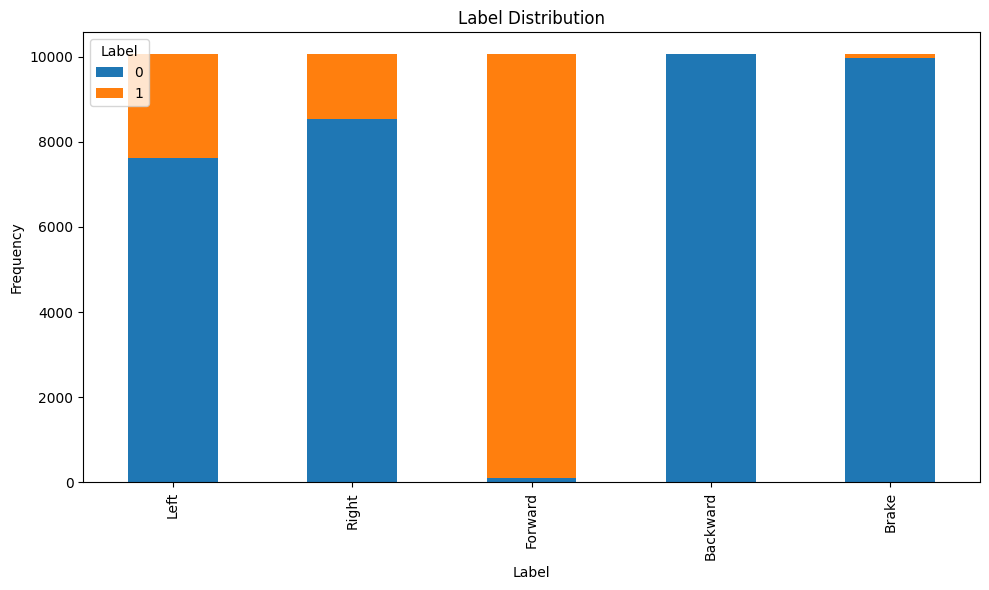

In [64]:
left_labels = data['left']
right_labels = data['right']
forward_labels = data['forward']
backward_labels = data['backward']
brake_labels = data['brake']

left_counts = left_labels.value_counts()
right_counts = right_labels.value_counts()
forward_counts = forward_labels.value_counts()
backward_counts = backward_labels.value_counts()
brake_counts = brake_labels.value_counts()

df = pd.DataFrame({
    'Left': left_counts,
    'Right': right_counts,
    'Forward': forward_counts,
    'Backward': backward_counts,
    'Brake': brake_counts
}).transpose()

# Plot the distribution of labels
fig, ax = plt.subplots(figsize=(10, 6))

df.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Label Distribution')
ax.set_xlabel('Label')
ax.set_ylabel('Frequency')
ax.legend(['0', '1'], title='Label')

plt.tight_layout()
plt.show()

## Preprocessing Data

In [65]:
def load_image(image_path):
    image = Image.open("../"+image_path)
    image = np.array(image)
    return image

In [66]:
data['path'][0]

'outputs/training_data/10.jpeg'

In [67]:
images = [load_image(image_path) for image_path in data['path']]
images = np.array(images)

In [68]:
images[0].shape

(64, 64)

In [69]:
# mean = np.mean(images, axis=(0, 1, 2))
# std = np.std(images, axis=(0, 1, 2))
# scaled_images = (images - mean) / std

In [70]:
targets = data[['left', 'right', 'forward', 'brake']].values

## Splitting Data

In [71]:
X_train, X_temp, y_train, y_temp = train_test_split(
    images, targets, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42)

In [72]:
len(X_train)

8056

In [73]:
len(X_test)

1007

In [74]:
sample_image_path = "../outputs/training_data/10.jpeg"
sample_image = Image.open(sample_image_path)
image_width, image_height = sample_image.size
num_channels = len(sample_image.getbands())

In [75]:
num_channels

1

# Neural Network

## Model Set Up

In [76]:
optimizer = Adam(learning_rate=0.001)

In [77]:
# model = models.Sequential([
#     layers.Conv2D(32, (3, 3), activation='relu', input_shape=(
#         image_height, image_width, num_channels)),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu',
#                   kernel_regularizer=regularizers.l2(0.0001)),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu',
#                   kernel_regularizer=regularizers.l2(0.0001)),
#     layers.Flatten(),
#     layers.Dense(64, activation='relu',
#                  kernel_regularizer=regularizers.l2(0.0001)),
#     layers.Dropout(0.6),
#     layers.Dense(4, activation='sigmoid')
# ])

In [78]:
model = models.Sequential([
    layers.Conv2D(128, (3, 3), activation='relu', input_shape=(
        image_height, image_width, num_channels)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(40, activation='relu'),
    layers.Dropout(0.6),
    layers.Dense(4, activation='relu')
])

In [79]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 62, 128)       1280      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 31, 31, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 29, 32)        36896     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 6272)              0         
                                                                 
 dense_4 (Dense)             (None, 40)               

## Training Model

In [80]:
model.compile(optimizer=optimizer, loss='mse')

In [81]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10


252/252 [==============================] - 15s 59ms/step - loss: 3.2481 - val_loss: 0.1814
Epoch 2/10
252/252 [==============================] - 14s 56ms/step - loss: 0.2486 - val_loss: 0.1840
Epoch 3/10
252/252 [==============================] - 14s 56ms/step - loss: 0.2467 - val_loss: 0.1794
Epoch 4/10
252/252 [==============================] - 14s 57ms/step - loss: 0.2268 - val_loss: 0.1524
Epoch 5/10
252/252 [==============================] - 15s 58ms/step - loss: 0.1753 - val_loss: 0.1233
Epoch 6/10
252/252 [==============================] - 15s 58ms/step - loss: 0.1394 - val_loss: 0.1084
Epoch 7/10
252/252 [==============================] - 15s 59ms/step - loss: 0.1175 - val_loss: 0.0939
Epoch 8/10
252/252 [==============================] - 15s 58ms/step - loss: 0.1035 - val_loss: 0.0855
Epoch 9/10
252/252 [==============================] - 15s 59ms/step - loss: 0.0895 - val_loss: 0.0718
Epoch 10/10
252/252 [==============================] - 15s 58ms/step - loss: 0.0824 - val_los

## Testing Model

In [82]:
test_loss = model.evaluate(X_test, y_test)

32/32 [==============================] - 1s 16ms/step - loss: 0.0668


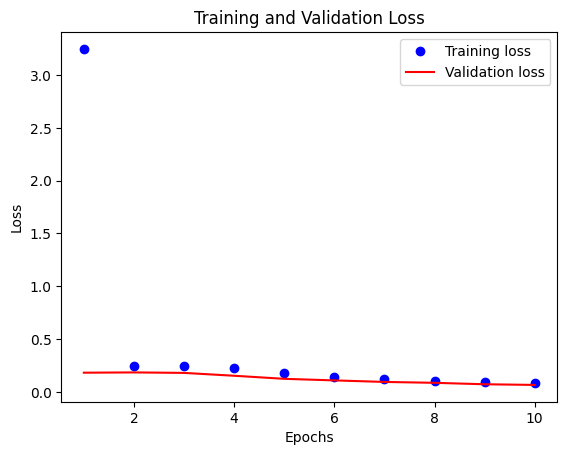

In [83]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

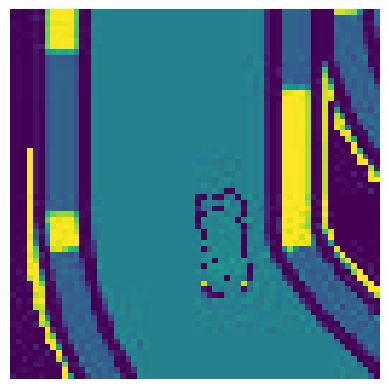

In [84]:
image = X_test[5]
plt.imshow(image)
plt.axis('off')
plt.show()

In [85]:
test_image = image.reshape(1, image_height, image_width, num_channels)
predictions = model.predict(test_image)
print(predictions)

1/1 [==============================] - 0s 56ms/step
[[0.07513606 0.         0.93568057 0.        ]]


## Prediction Distribution

In [86]:
predictions_list = []
for num in range(250):
    image = X_test[num]
    test_image = image.reshape(1, image_height, image_width, num_channels)
    prediction = model.predict(test_image)
    predictions_list.append(prediction)

1/1 [==============================] - 0s 19ms/step


In [87]:
predictions_list

[array([[0.31041226, 0.        , 0.9663179 , 0.        ]], dtype=float32),
 array([[0.4919658, 0.       , 0.9899596, 0.       ]], dtype=float32),
 array([[0.39078918, 0.        , 0.97678447, 0.        ]], dtype=float32),
 array([[0.        , 0.        , 0.92323864, 0.        ]], dtype=float32),
 array([[0.05188952, 0.        , 0.9326534 , 0.        ]], dtype=float32),
 array([[0.07513606, 0.        , 0.93568057, 0.        ]], dtype=float32),
 array([[0.06945804, 0.        , 0.9349412 , 0.        ]], dtype=float32),
 array([[0.0603088, 0.       , 0.9337498, 0.       ]], dtype=float32),
 array([[0.        , 0.        , 0.92323864, 0.        ]], dtype=float32),
 array([[0.05145548, 0.        , 0.9325969 , 0.        ]], dtype=float32),
 array([[0.25951487, 0.        , 0.95969015, 0.        ]], dtype=float32),
 array([[0.       , 0.       , 1.0201387, 0.       ]], dtype=float32),
 array([[0.       , 0.       , 0.9237573, 0.       ]], dtype=float32),
 array([[0.        , 0.        , 0.923238

In [88]:
for num in range(250):
    print(y_test[num])

[1 0 1 0]
[1 0 1 0]
[1 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 1 1 0]
[1 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[1 0 1 0]
[1 0 1 0]
[1 0 1 0]
[1 0 1 0]
[1 0 1 0]
[1 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[1 0 1 0]
[1 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[1 0 1 0]
[0 0 1 0]
[0 1 1 0]
[0 0 1 0]
[0 1 1 0]
[0 0 1 0]
[1 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[1 0 1 0]
[0 1 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 1 1 0]
[1 0 1 0]
[1 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 1 1 0]
[0 0 1 0]
[0 0 1 0]
[1 0 1 0]
[1 0 1 0]
[0 0 1 0]
[0 0 1 0]
[1 0 1 0]
[1 0 1 0]
[0 1 1 0]
[1 0 1 0]
[0 1 1 0]
[1 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 1 1 0]
[0 0 1 0]
[1 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 1 1 0]
[0 1 1 0]
[0 0 1 0]
[1 0 1 0]
[0 0 1 0]
[0 0 1 0]
[0 1 1 0]
[0 0 1 0]
[1 0 1 0]
[1 0 1 0]
[1 0 1 0]
[0 0 1 0]
[1 0 1 0]
[0 1 1 0]
[0 0 1 0]
[1 0 1 0]
[0 0 1 0]
[0 1 1 0]
[0 0 1 0]


## Saving Model Weights

In [89]:
model.save("../models/CNN_steering_model_gs_64.h5")

c:\Users\andyx\Desktop\Projects\SelfDrivingCarSimulator\env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
